In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import itertools

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy

import collections
import random

from Intersection import Lane, Approach, Intersection, Exit, Trafficlight, TrafficLightGroup

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
# Exit N
exit_n_r = Lane([0], None, True, None)
exit_n = Exit(0, [exit_n_r])

# Exit E
exit_e_r = Lane([0], None, True, None)
exit_e_l = Lane([0], None, True, None)
exit_e = Exit(1, [exit_e_r, exit_e_l])

# Exit S
exit_s_r = Lane([0], None, True, None)
exit_s = Exit(2, [exit_s_r])

# Exit W
exit_w_r = Lane([0], None, True, None)
exit_w_l = Lane([0], None, True, None)
exit_w = Exit(3, [exit_w_r, exit_w_l])

# Approach N
traffic_light_n_r = Trafficlight(0, [1], 0, 1, 2)
traffic_light_n_l = Trafficlight(1, [0, 2], 0, 1, 2)

lane_n_r = Lane([1], traffic_light_n_r, False, [exit_w_r])
lane_n_l = Lane([0, 2], traffic_light_n_l, False, [exit_s_r, exit_e_l])

approach_n = Approach(0, [lane_n_r, lane_n_l], 90)

# Approach E
traffic_light_e_r = Trafficlight(2, [0, 1], 0, 1, 2)
traffic_light_e_m = Trafficlight(3, [0], 0, 1, 2)
traffic_light_e_l = Trafficlight(4, [2], 0, 1, 2)

lane_e_r = Lane([0, 1], traffic_light_e_r, False, [exit_n_r, exit_w_r])
lane_e_m = Lane([0], traffic_light_e_m, False, [exit_w_l])
lane_e_l = Lane([2], traffic_light_e_l, False, [exit_s_r])

approach_e = Approach(1, [lane_e_r, lane_e_m, lane_e_l], 0)

# Approach S
traffic_light_s_r = Trafficlight(5, [0, 1], 0, 1, 2)
traffic_light_s_l = Trafficlight(6, [2], 0, 1, 2)

lane_s_r = Lane([0, 1], traffic_light_s_r, False, [exit_e_r, exit_n_r])
lane_s_l = Lane([2], traffic_light_s_l, False, [exit_w_l])

approach_s = Approach(2, [lane_s_r, lane_s_l], 270)

# Approach W
traffic_light_w_r = Trafficlight(7, [0, 1], 0, 1, 2)
traffic_light_w_m = Trafficlight(8, [0], 0, 1, 2)
traffic_light_w_l = Trafficlight(9, [2], 0, 1, 2)

lane_w_r = Lane([0, 1], traffic_light_w_r, False, [exit_s_r, exit_e_r])
lane_w_m = Lane([0], traffic_light_w_m, False, [exit_e_l])
lane_w_l = Lane([2], traffic_light_w_l, False, [exit_n_r])

approach_w = Approach(3, [lane_w_r, lane_w_m, lane_w_l], 180)

traffic_light_group_ns_s = TrafficLightGroup([traffic_light_n_r, traffic_light_n_l, traffic_light_s_r, traffic_light_s_l])
traffic_light_group_ew_s = TrafficLightGroup([traffic_light_e_r, traffic_light_e_m, traffic_light_w_r, traffic_light_w_m])
traffic_light_group_ew_l = TrafficLightGroup([traffic_light_e_l, traffic_light_w_l])

u =  [7, 7, 5, 7, 7, 7, 7, 5, 7, 7] # 8 & 4
i =  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

V = [[1, 1, 0, 0, 0, 1, 1, 0, 0, 0],
     [0, 0, 0, 1, 1, 0, 0, 0, 1, 1],
     [0, 0, 1, 0, 0, 0, 0, 1, 0, 0]]

m = len(V)
a_max = 5

intersection = Intersection([approach_n, approach_e, approach_s, approach_w], [exit_n, exit_e, exit_s, exit_w], [traffic_light_group_ns_s, traffic_light_group_ew_s, traffic_light_group_ew_l], u, i, V, a_max)

## Policy Gradient Reinforce

In [3]:
# class PolicyGradientReinforce:
#     def __init__(self, env, action_space):
#         self.env = env
#         self.state_shape = [10]
#         self.action_space = np.array(action_space)
#         self.action_shape = len(self.action_space)
#         self.gamma = 0.99  # decay rate of past observations
#         self.alpha = 1e-4  # learning rate of gradient
#         self.learning_rate = 0.01  # learning of deep learning model

#         self.model = self.build_policy_network()

#         # Observations
#         self.states = []
#         self.gradients = []
#         self.rewards = []
#         self.probs = []
#         self.discounted_rewards = []
#         self._total_rewards = []
#         self.totalcars = []

#     def build_policy_network(self):
#         model = Sequential()
#         model.add(Dense(8, input_shape=self.state_shape, activation="relu"))
#         model.add(Dense(12, activation="relu"))
#         model.add(Dropout(0.2))
#         model.add(Dense(self.action_shape, activation="softmax"))
#         model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=self.learning_rate))
#         return model

#     def hot_encode_action(self, action):
#         action_encoded = np.zeros(self.action_shape)
#         action_encoded[action] = 1
#         return action_encoded

#     def remember(self, state, action, action_prob, reward):
#         encoded_action = self.hot_encode_action(action)
#         self.gradients.append(encoded_action-action_prob)
#         self.states.append(state)
#         self.rewards.append(reward)
#         self.probs.append(action_prob)

#     def compute_action(self, state):
#         # transform state
#         state = state.reshape([1, state.shape[0]])
#         # print('State:', state)
#         # get action probably
#         action_probability_distribution = self.model.predict(state).flatten()
#         # print('Action Probability Distribution:', action_probability_distribution)
#         # norm action probability distribution
#         action_probability_distribution /= np.sum(action_probability_distribution)
#         # print('Norm Action Probability Distribution:', action_probability_distribution)

#         print(action_probability_distribution)

#         # sample action
#         action = np.random.choice(self.action_shape, 1, p=action_probability_distribution)[0]

#         # action = self.action_shape[np.argmax(action_probability_distribution)]

#         print(action)
#         # print('Action:', action)

#         return self.action_space[action], action_probability_distribution

#     def get_discounted_rewards(self, rewards):
#         discounted_rewards = []
#         cumulative_total_return = 0
#         # iterate the rewards backwards and calc the total return
#         for reward in rewards[::-1]:
#             cumulative_total_return = (cumulative_total_return*self.gamma)+reward 
#             discounted_rewards.insert(0, cumulative_total_return)

#         # normalize discounted rewards
#         mean_rewards = np.mean(discounted_rewards)
#         std_rewards = np.std(discounted_rewards)
#         norm_discounted_rewards = (discounted_rewards-mean_rewards)/(std_rewards+1e-7)  # avoiding zero div

#         return norm_discounted_rewards

#     def train_policy_network(self):
#         # get X_train
#         states = np.vstack(self.states)

#         # get y_train
#         gradients = np.vstack(self.gradients)
#         rewards = np.vstack(self.rewards)
#         discounted_rewards = self.get_discounted_rewards(rewards)
#         gradients *= discounted_rewards
#         y_train = self.alpha*np.vstack([gradients])+self.probs
#         # y_train = gradients
#         history = self.model.train_on_batch(states, y_train)

#         self.states, self.probs, self.gradients, self.rewards = [], [], [], []

#         return history

#     def train(self, episodes):
#         env = self.env
#         total_rewards = np.zeros(episodes)

#         for episode in range(episodes):
#             # each episode is a new game env
#             state = env.reset()
#             done = False
#             episode_reward = 0  # record episode reward

#             while not done:
#                 # play an action and record the game state & reward per episode
#                 action, prob = self.compute_action(state)
#                 print('Action sent:', action)
#                 next_state, reward, done, _ = env.step(action)
#                 self.totalcars.append(env.get_cars_per_lane())
#                 self.remember(state, action, prob, reward)
#                 state = next_state
#                 episode_reward += reward

#                 # if episode%render_n==0: ## render env to visualize.
#                 # env.render()
#                 if done:
#                     # update policy
#                     history = self.train_policy_network()

#             total_rewards[episode] = episode_reward
#             print('Episode = ', episode)

#         self._total_rewards = total_rewards

#     def hot_encode_action(self, action):
#         action_encoded = np.zeros(self.action_shape)
#         action_encoded[action] = 1

#         return action_encoded

#     def remember(self, state, action, action_prob, reward):
#         encoded_action = self.hot_encode_action(action)
#         self.gradients.append(encoded_action-action_prob)
#         self.states.append(state)
#         self.rewards.append(reward)
#         self.probs.append(action_prob)

#     @property
#     def total_cars(self):
#         return self.totalcars

#     @property
#     def total_rewards(self):
#         return self._total_rewards


In [4]:
# intersection.reset()

# action_space = itertools.product(np.arange(0, a_max), repeat=m)
# action_space = np.array(list(action_space))
# action_space = action_space[~np.sometrue(action_space == 0, axis=1)]

# agent = PolicyGradientReinforce(intersection, action_space)
# agent.train(150)

## DQN

In [5]:
class DQAgent:
    def __init__(self, replayCapacity, action_space):
        ## Initialize replay memory
        self.capacity = replayCapacity
        self.memory = collections.deque(maxlen=self.capacity)
        self.populated = False
        ## q network


        self.state_shape = [10]
        self.action_space = np.array(action_space)
        self.action_shape = len(self.action_space)

        self.q_model = self.buildNetwork()
        ## Target network
        self.target_model = self.buildNetwork()
        self.target_model.set_weights(self.q_model.get_weights())

    def addToReplayMemory(self, step):
        self.step = step
        self.memory.append(self.step)

    def sampleFromReplayMemory(self, batchSize):
        self.batchSize = batchSize
        if self.batchSize > len(self.memory):
            self.populated = False
            return self.populated
        else:
            return random.sample(self.memory, self.batchSize)

    def buildNetwork(self):
        model = Sequential()
        model.add(Dense(32, input_shape=self.state_shape, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))

        model.add(Dense(48, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        
        model.add(Dense(self.action_shape, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr = 0.001), metrics=['MeanSquaredError'])
        return model

    def q_network_fit(self,batch, batchSize):
        self.batchSize = batchSize
        self.batch = batch

    def q_network_predict(self, state):
        self.state = state
        self.qPolicy = self.q_model.predict(self.state)
        return self.qPolicy

    def target_network_predict(self, state):
        self.state = state
        self.qTarget = self.target_model.predict(self.state)
        return self.qTarget

    def update_target_network(self):
        self.target_model.set_weights(self.q_model.get_weights())

In [6]:
DISCOUNT = 0.90
REPLAY_MEMORY_CAPACITY = 10000
#MIN_REPLAY_MEMORY_SIZE = 1_000  # Minimum number of steps in a memory to start training
BATCH_SIZE = 64  # How many steps (samples) to use for training
UPDATE_TARGET_INTERVAL = 50
EPSILON = 0.95 # Exploration percentage
MIN_EPSILON = 0.01
DECAY = 0.9999

state = intersection.reset()
done =  False

action_space = itertools.product(np.arange(0, a_max), repeat=m)
action_space = np.array(list(action_space))
action_space = action_space[~np.sometrue(action_space == 0, axis=1)]

POSSIBLE_ACTIONS = np.arange(0, len(action_space)).tolist()
agent = DQAgent(replayCapacity= REPLAY_MEMORY_CAPACITY, action_space=action_space)

c:\Users\arthu\.conda\envs\ResearchProject\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [7]:
updateCounter = 0
rewardHistory = []

action_space = itertools.product(np.arange(0, a_max), repeat=m)
action_space = np.array(list(action_space))
action_space = action_space[~np.sometrue(action_space == 0, axis=1)]


for episode in range(50):
    episodeReward = 0
    stepCounter = 0  # count the number of successful steps within the episode

    #print('\n', episode)
    state = intersection.reset()
    done = False
    #state = np.expand_dims(state, axis=0)

    while not done :
        r = random.random()

        if r <= EPSILON:
            action = random.sample(POSSIBLE_ACTIONS, 1)[0]
            print(action)
            #print('exploration')
        else:
            #print('exploitation')
            qValues = agent.q_network_predict(state.reshape(1,-1))
            action = np.argmax(qValues[0])
            #print('action =', action)
            #print(qValues)

        newState, reward, done, info = intersection.step(action_space[action])

        stepCounter +=1
        #print('stepcounter = ', stepCounter)

        #newState = np.expand_dims(newState, axis=0)
        # store step in replay memory
        step = (state, action, reward, newState, done)
        agent.addToReplayMemory(step)
        state = newState
        episodeReward += reward
        #print('episodeReward = ',episodeReward)
        # When enough steps in replay memory -> train policy network
        if len(agent.memory) >= (BATCH_SIZE ):
            EPSILON = DECAY * EPSILON
            print(EPSILON)
            if EPSILON < MIN_EPSILON:
                EPSILON = MIN_EPSILON
            # sample minibatch from replay memory
            miniBatch = agent.sampleFromReplayMemory(BATCH_SIZE)
            miniBatch_states = np.asarray(list(zip(*miniBatch))[0],dtype=float)
            miniBatch_actions = np.asarray(list(zip(*miniBatch))[1], dtype = int)
            miniBatch_rewards = np.asarray(list(zip(*miniBatch))[2], dtype = float)
            miniBatch_next_state = np.asarray(list(zip(*miniBatch))[3],dtype=float)
            miniBatch_done = np.asarray(list(zip(*miniBatch))[4],dtype=bool)

            current_state_q_values = agent.q_network_predict(miniBatch_states)
            y = current_state_q_values
            #print(y.shape)
            #miniBatch_next_state = np.squeeze(miniBatch_next_state, axis =1)

            next_state_q_values = agent.target_network_predict(miniBatch_next_state)
            #print(next_state_q_values.shape)
            max_q_next_state = np.max(next_state_q_values,axis=1)

            for i in range(BATCH_SIZE):
                if miniBatch_done[i]:
                    y[i,miniBatch_actions[i]] = miniBatch_rewards[i]
                else:
                    y[i,miniBatch_actions[i]] = miniBatch_rewards[i] + DISCOUNT * max_q_next_state[i]

            agent.q_model.fit(miniBatch_states, y, batch_size=BATCH_SIZE, verbose = 0)
            #print(y)

        else:
            # intersection.render()
            continue
        if updateCounter == UPDATE_TARGET_INTERVAL:
            agent.update_target_network()
            print('target updated')
            updateCounter = 0
        updateCounter += 1
    print('episodeReward for episode ', episode, '= ', episodeReward, 'with epsilon = ', EPSILON)
    rewardHistory.append(episodeReward)

intersection.close()

print(intersection.drukte_hist)

plt.plot(rewardHistory)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward per episode')
plt.show()

28
D1:  22146 | D2:  213444 | Drukte:  0.10375555180749986
Action:  [2 4 1] | Sum action M [14 14  5 28 28 14 14  5 28 28] | Reward:  0.9 | Drukte:  0.1 n [50 50 59 36 36 50 50 59 36 36]
62
D1:  20056 | D2:  183184 | Drukte:  0.10948554458904708
Action:  [4 4 3] | Sum action M [28 28 15 28 28 28 28 15 28 28] | Reward:  0.89 | Drukte:  0.11 n [44 44 66 30 30 44 44 66 30 30]
40
D1:  18842 | D2:  152100 | Drukte:  0.12387902695595003
Action:  [3 3 1] | Sum action M [21 21  5 21 21 21 21  5 21 21] | Reward:  0.88 | Drukte:  0.12 n [37 37 75 23 23 37 37 75 23 23]
33
D1:  18130 | D2:  142884 | Drukte:  0.12688614540466392
Action:  [3 1 2] | Sum action M [21 21 10  7  7 21 21 10  7  7] | Reward:  0.87 | Drukte:  0.13 n [28 28 77 28 28 28 28 77 28 28]
4
D1:  18100 | D2:  132496 | Drukte:  0.13660789759690858
Action:  [1 2 1] | Sum action M [ 7  7  5 14 14  7  7  5 14 14] | Reward:  0.86 | Drukte:  0.14 n [29 29 80 22 22 29 29 80 22 22]
14
D1:  19298 | D2:  125316 | Drukte:  0.15399470139487376

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


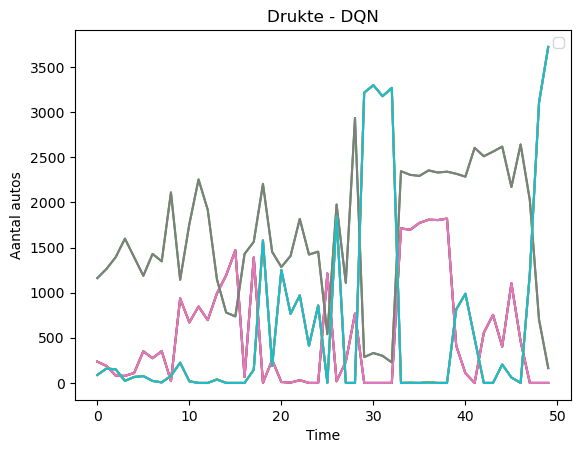

In [ ]:
#plot total cars
plt.plot(intersection.drukte_hist)
plt.xlabel('Time')
plt.ylabel('Aantal autos')
plt.title('Drukte - DQN')
plt.legend()
plt.show()